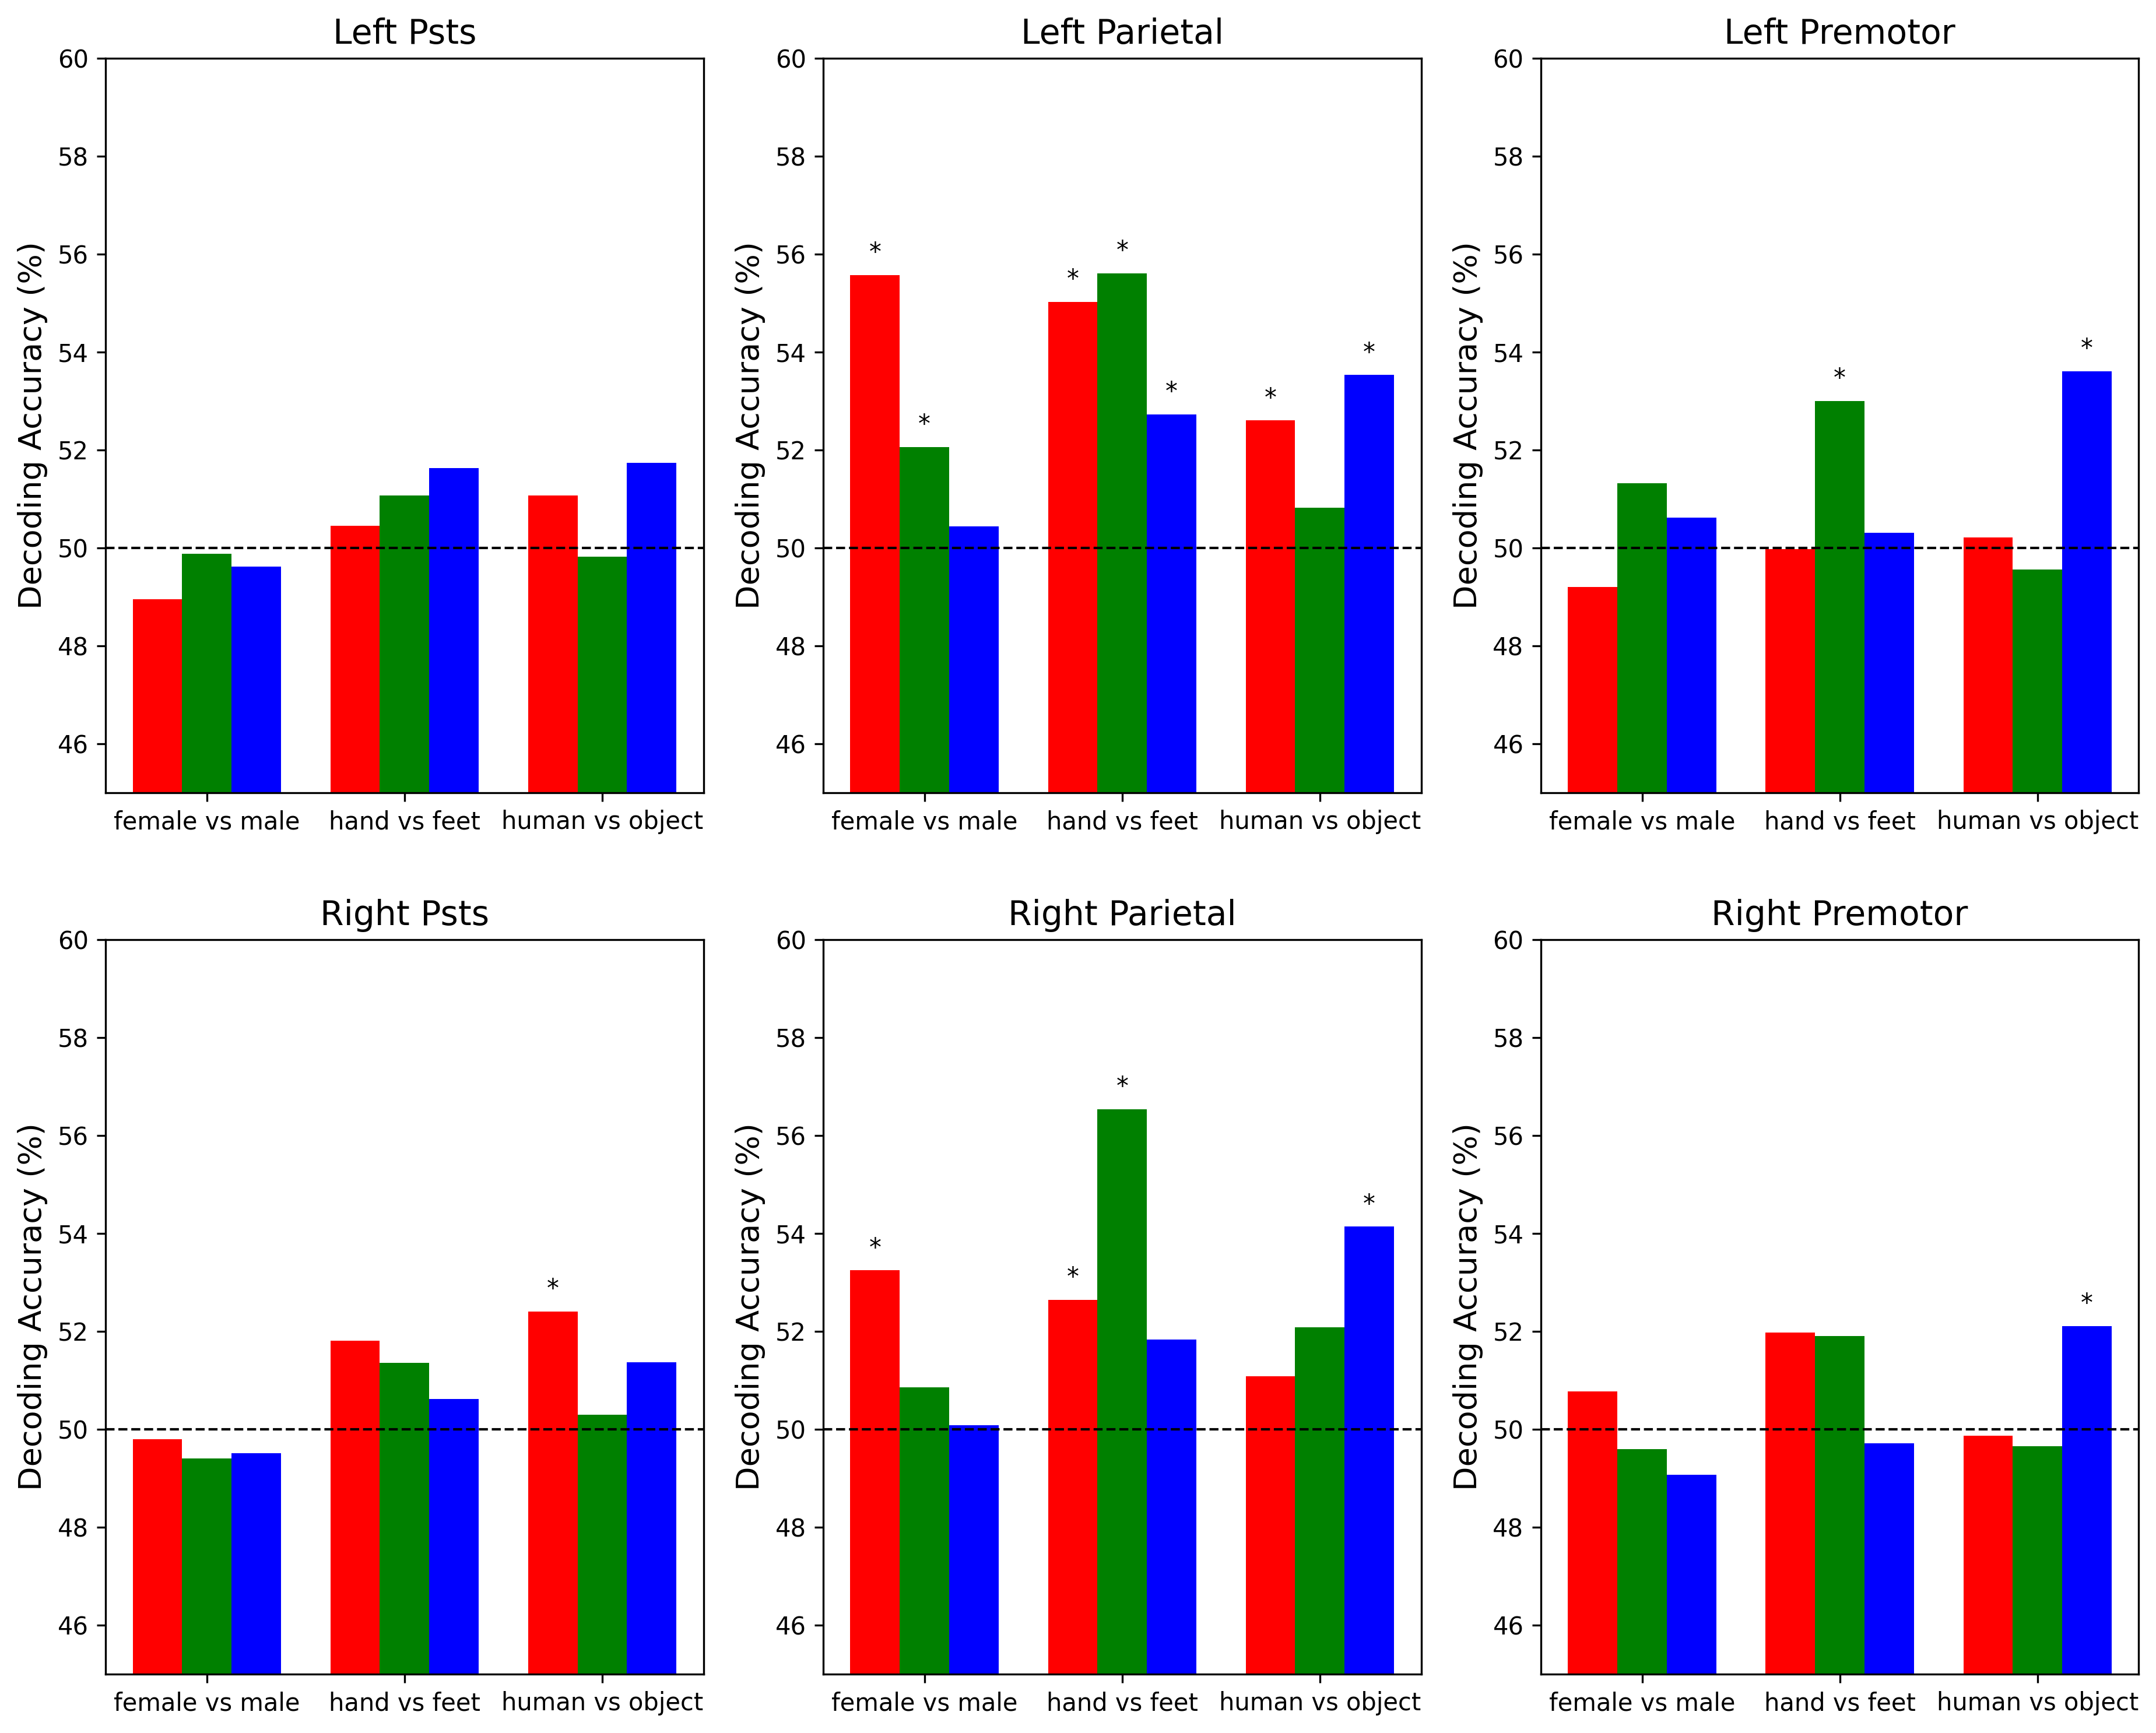

Supplementary table has been saved as 'supplementary_table.csv'.


In [1]:
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

# Load the dataset
# file_path = 'C:\\Users\\aslie\\Downloads\\decoding_results.csv'
file_path = r'C:\Users\aslie\Downloads\decoding_results.csv'
data = pd.read_csv(file_path)

# Initialize parameters
n_permutations = 10000  # Number of permutations
results = {}

# Perform permutation test for each column
for column in data.columns:
    # Drop missing values (if any)
    values = data[column].dropna().values

    # Observed mean
    observed_mean = np.mean(values)

    # Generate the null distribution by shuffling signs
    null_distribution = []
    for _ in range(n_permutations):
        permuted_values = values * np.random.choice([-1, 1], size=len(values))
        null_distribution.append(np.mean(permuted_values))

    # Calculate the p-value (one-tailed test for greater than zero)
    null_distribution = np.array(null_distribution)
    p_value = np.sum(null_distribution >= observed_mean) / n_permutations

    # Store the results
    results[column] = {
        'observed_mean': observed_mean,
        'p_value': p_value
    }

# Extract p-values from the results
p_values = [results[column]['p_value'] for column in data.columns]

# Apply FDR correction
fdr_corrected = multipletests(p_values, method='fdr_bh')

# Add corrected p-values and significance flags to results
for i, column in enumerate(data.columns):
    results[column]['p_value_fdr'] = fdr_corrected[1][i]
    results[column]['significant_fdr'] = fdr_corrected[0][i]

# Convert updated results to a DataFrame
results_df = pd.DataFrame(results).T

# Parse column names dynamically
parsed_columns = [col.split(',') for col in data.columns]
results_df['hemisphere'] = [parsed[0].strip().lower() for parsed in parsed_columns]
results_df['region'] = [parsed[1].strip().lower() for parsed in parsed_columns]
results_df['task'] = [parsed[2].strip().lower() for parsed in parsed_columns]
results_df['feature'] = [parsed[3].strip() for parsed in parsed_columns]

# Visualization of FDR significant results with bar plots
plt.figure(figsize=(15, 12), dpi=300)
regions = ['psts', 'parietal', 'premotor']  # Ensure case matches parsed values
features = ['woman vs man', 'hand vs feet', 'human vs object']  # Example features
hemispheres = ['left', 'right']

feature_name_mapping = {
    'woman vs man': 'female vs male',
    'hand vs feet': 'hand vs feet',  # Keep unchanged
    'human vs object': 'human vs object'  # Keep unchanged
}
# Update features list to use display names
features = list(feature_name_mapping.values())

tasks = ['actor', 'effector', 'target']  # Example tasks with color coding
colors = {'actor': 'red', 'effector': 'green', 'target': 'blue'}

data_to_plot = []  # Store data for plotting
handles = []  # Collect bar handles for legend
labels = []   # Collect corresponding labels

# Create subplots
for i, region in enumerate(regions):
    for j, hemisphere in enumerate(hemispheres):
        ax = plt.subplot(len(hemispheres), len(regions), i + 1 + j * len(regions))
        bar_width = 0.25  # Width of each bar group
        x = np.arange(len(features))  # X-axis positions for features

        for k, task in enumerate(tasks):
            # Compute mean values and significance for the specific combination
            means = []
            significances = []
            for feature in features:
                original_feature = [key for key, value in feature_name_mapping.items() if value == feature]
                if original_feature:
                    subset = results_df[(results_df['hemisphere'] == hemisphere) &
                                        (results_df['region'] == region) &
                                        (results_df['task'] == task) &
                                        (results_df['feature'] == original_feature[0])]
                    if not subset.empty:
                        means.append(subset['observed_mean'].values[0] + 50)
                        significances.append(subset['significant_fdr'].values[0])
                    else:
                        means.append(np.nan)
                        significances.append(False)
                else:
                    means.append(np.nan)  # Handle unexpected cases
                    significances.append(False)

            # Plot bars for the task
            bars = ax.bar(x + k * bar_width, means, bar_width, label=task, color=colors[task])

            # Collect handles and labels for legend
            if i == 0 and j == 0:  # Only collect once
                handles.append(bars[0])
                labels.append(task)

            # Add significance stars
            for bar, sig in zip(bars, significances):
                if sig:
                    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, '*', ha='center', va='bottom', color='black')

        # Add dashed line at 50%
        ax.axhline(y=50, color='black', linestyle='--', linewidth=1)

        # Customize subplot
        ax.set_xticks(x + bar_width)
        ax.set_xticklabels(features, rotation=0, ha='center')
        ax.set_title(f"{hemisphere.capitalize()} {region.capitalize()}", fontsize=14)
        ax.set_ylim(45, 60)  # Adjust limits to reflect decoding accuracy with better detail
        ax.set_ylabel("Decoding Accuracy (%)", fontsize=13)

# Add the legend outside the plot
#plt.legend(handles, labels, title="Tasks", loc="center right", bbox_to_anchor=(1.43, 1.2), frameon=False, prop={'size': 12}, title_fontsize=13)  # Adjust legend title font size)

#plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit legend
plt.savefig("decoding_results_active.png", dpi=300)  # Save figure at 300 DPI
plt.show()

# Create a table for supplementary materials
supplementary_table = results_df[['observed_mean', 'p_value', 'p_value_fdr']]

# Save the supplementary table to a CSV file
supplementary_table.to_csv("supplementary_table.csv", index=True)

print("Supplementary table has been saved as 'supplementary_table.csv'.")
